# Day4 「Pythonテトリス」の作り方
テトリスは、ミノが置かれていない状態を「0」、I字型のミノを「1」、L字型のミノを「2」・・・と数字で呼ぶことにして、<br>
`0`から`7`までの数字が`22`段 × `10`列 = `220`個並んだ「NumPy配列」によって表現されている、とDay2で述べました。<br><br>

テトリスのコードの仕組みを把握するポイントは、
<b>

1. ミノの形・回転・移動・落下というルールを、「NumPy配列」によってどうやって表現できる？
1. ミノをどの向きでどこに落とすか、どうやって決めればいい？

</b>
という2点です。<br>
文法学習が終わって中盤戦に入るDay4では、本番で使われるコードでこれらの実装を確認し、実際に挙動を試してみることでその理解を深めます。<br>

## 0. チュートリアルのゴール
<b>ルールベースの場合には`block_controller.py`を、AIの場合には`block_controller_train.py`を書き換えられる</b>ようになることが、学習のゴールです。

### 文法学習の補足
Day3までの文法学習では、1つの`.py`ファイルや`.ipynb`ファイルでコードを書いてきました。<br>
しかし、このテトリスなどのゲームや実際の製品でコードが数百〜数万行にまで膨れてくると、1つのファイルでは行数が多くて読みづらくなってしまいます。<br>
そこでPythonでは、複数のファイルにコードを分割することができます。<br>
実は今まで「おまじない」として使っていた`import`文の正体は、別のファイルにあるコードを使うための文法でした。<br><br>

試しに下のセルを実行してみてください。<br>
このセルにはクラスの定義文はおろか`print`文もないのに、いかにもクラスの関数を使用しているっぽい1行が書かれている上に、ある一文が出力されます。<br><br>

これは、同じにフォルダに保存された`import_tutorial.py`という別のファイルにあるコードを実行しているからです。<br>
`import_tutorial.py`には、文字を表示する機能である関数`printChar()`と、その文字を保存した変数`self.s`を定義する「コンストラクタ」を持つ、`ImportTutorial()`クラスが定義されています。<br>
クラスの持つ変数や機能を使うためにはクラスの「インスタンス」を作る必要があり、それは13行目で`IMPORT_TUTORIAL`という名前でなされています。<br><br>

テトリスの本番コードでも同じように、別のファイルにあるクラスが使われるときには<br>
`from (別のファイル名から拡張子「.py」を除いたもの) import (インスタンスを作った変数の名前)`<br>
とコードの冒頭に書かれていて、「別のファイルから変数を自分のコードに取り込できなさい」という命令を表しています。

In [108]:
from import_tutorial import IMPORT_TUTORIAL
IMPORT_TUTORIAL.printChar()

ModuleNotFoundError: No module named 'import_tutorial'

### 本番コードのファイル構成
複数ファイルにコードが分割されていても実行する方法があることを知った上で、テトリスの本番コードにおける`.py`ファイルの場所と役割を、<b><a href="https://github.com/seigot/tetris/tree/master#%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E6%A7%8B%E6%88%90">GitHubのREADMEファイル</a></b>で確認しておきましょう。<br><br>

テトリスを実行するときコマンドプロンプトやターミナルに<br>
`python start.py`<br>
という一行を入力して`Enter`キーを押していますが、これは「`start.py`の中身を実行せよ」という命令を意味していました。<br>
READMEの図は`start.py`を起点に、複数のファイルにまたがったクラスを呼び出している繋がりを表しています。<br><br>

上で述べた

- ミノの形・回転・移動・落下というルール

やゲーム画面の表示は、`game_manager`フォルダにある`game_manager.py`という<b>ゲーム管理用プログラム</b>と、`board_manager.py`という<b>ルール管理用プログラム</b>に、

- ミノをどの向きでどこに落とすか

という、皆さんに作っていただきたいミノの落とし方の作戦は、同じく`game_manager`フォルダにある`block_controller.py`、<br>
もしくは`game_manager`フォルダの中の`machne_learning`フォルダにある`block_controller_train.py`という<b>ブロック操作用プログラム</b>に、それぞれ実装されています。<br><br>

`block_controller.py`もしくは`block_controller_train.py`の中でも、<b>関数`GetNextMove()`が落とし方の作戦を計算している</b>部分です。<br>
本チュートリアルは、この関数で登場するミノの落とし方や作戦の計算方法を学ぶことが目的です。<br>
詳しい作りや流れはさておき、<span style="color: red; ">**実際にコードを読むときにはチュートリアル以上の内容は読み込まなくて問題ない**</span>ように、必要な部分だけを本番コードから抜き出して作っています。

<div align="center">
<img src="img/tetris_mermaid.png" width="500">
</div>

In [51]:
import copy
class Shape(object):
    shapeNone = 0
    shapeI = 1
    shapeL = 2
    shapeJ = 3
    shapeT = 4
    shapeO = 5
    shapeS = 6
    shapeZ = 7

    # shape1 : ****
    #          ----
    #          ----
    #
    # shape2 : -*--
    #          -*--
    #          -**-
    #
    # shape3 : --*-
    #          --*-
    #          -**-
    #
    # shape4 : -*--
    #          -**-
    #          -*--
    #
    # shape5 : -**-
    #          -**-
    #          ----
    #
    # shape6 : -**-
    #          **--
    #          ----
    #
    # shape7 : **--
    #          -**-
    #          ----
    #
    #テトリミノ形状座標タプル
    shapeCoord = (
        ((0, 0), (0, 0), (0, 0), (0, 0)),
        ((0, -1), (0, 0), (0, 1), (0, 2)),
        ((0, -1), (0, 0), (0, 1), (1, 1)),
        ((0, -1), (0, 0), (0, 1), (-1, 1)),
        ((0, -1), (0, 0), (0, 1), (1, 0)),
        ((0, 0), (0, -1), (1, 0), (1, -1)),
        ((0, 0), (0, -1), (-1, 0), (1, -1)),
        ((0, 0), (0, -1), (1, 0), (-1, -1))
    )

    def __init__(self, shape=0):
        self.shape = shape

    ##############################
    # テトリミノ形状を回転した座標を返す
    # direction: テトリミノ回転方向
    ##############################
    def getRotatedOffsets(self, direction):
        # テトリミノ形状座標タプルを取得
        tmpCoords = Shape.shapeCoord[self.shape]
        # 方向によってテトリミノ形状座標タプルを回転させる
        if direction == 0 or self.shape == Shape.shapeO:
            return ((x, y) for x, y in tmpCoords)

        if direction == 1:
            return ((-y, x) for x, y in tmpCoords)

        if direction == 2:
            if self.shape in (Shape.shapeI, Shape.shapeZ, Shape.shapeS):
                return ((x, y) for x, y in tmpCoords)
            else:
                return ((-x, -y) for x, y in tmpCoords)

        if direction == 3:
            if self.shape in (Shape.shapeI, Shape.shapeZ, Shape.shapeS):
                return ((-y, x) for x, y in tmpCoords)
            else:
                return ((y, -x) for x, y in tmpCoords)

    ###################
    # direction (回転状態)のテトリミノ座標配列を取得し、それをx,yに配置した場合の座標配列を返す
    ###################
    def getCoords(self, direction, x, y):
        return ((x + xx, y + yy) for xx, yy in self.getRotatedOffsets(direction))

    ###################
    # テトリミノが原点から x,y 両方向に最大何マス占有するのか返す
    ###################
    def getBoundingOffsets(self, direction):
        # テトリミノ形状を回転した座標を返す
        tmpCoords = self.getRotatedOffsets(direction)
        # 
        minX, maxX, minY, maxY = 0, 0, 0, 0
        for x, y in tmpCoords:
            if minX > x:
                minX = x
            if maxX < x:
                maxX = x
            if minY > y:
                minY = y
            if maxY < y:
                maxY = y
        return (minX, maxX, minY, maxY)

def getShapeCoordArray(Shape_class, direction, x, y):
    #
    # get coordinate array by given shape.
    #
    coordArray = Shape_class.getCoords(direction, x, y) # get array from shape direction, x, y.
    return coordArray

def getBoard(board_backboard, Shape_class, direction, x):
    # 
    # get new board.
    #
    # copy backboard data to make new board.
    # if not, original backboard data will be updated later.
    board = copy.deepcopy(board_backboard)
    _board = dropDown(board, Shape_class, direction, x)
    return _board

def dropDown(board, Shape_class, direction, x):
    # 
    # internal function of getBoard.
    # -- drop down the shape on the board.
    # 
    dy = 22 - 1
    coordArray = getShapeCoordArray(Shape_class, direction, x, 0)
    # update dy
    for _x, _y in coordArray:
        _yy = 0
        while _yy + _y < 22 and (_yy + _y < 0 or board[(_y + _yy) * 10 + _x] == 0):
            _yy += 1
        _yy -= 1
        if _yy < dy:
            dy = _yy
    # get new board
    _board = dropDownWithDy(board, Shape_class, direction, x, dy)
    return _board

def dropDownWithDy(board, Shape_class, direction, x, dy):
    #
    # internal function of dropDown.
    #
    _board = board
    coordArray = getShapeCoordArray(Shape_class, direction, x, 0)
    for _x, _y in coordArray:
        _board[(_y + dy) * 10 + _x] = Shape_class.shape
    return _board

In [98]:
#ブロック可視化関数 (numpy 配列からテトリスの盤面を可視化)
def visualize_block(board, shape, size=0.5):
    board = board.reshape(shape)
    block_array = []
    fig, ax = plt.subplots()
    fig.set_figwidth(shape[0] * size)
    fig.set_figheight(shape[1] * size)
    for i in range(shape[0]):
        row = []
        for j in range(shape[1]):
            c = colors[int(board[i][j])]
            row.append(c)
        block_array.append(row)
    block_array = np.array(block_array)
    im = plt.imshow(block_array)

    #グリッド線を引く
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 23, 1.0), minor=True)
    ax.set_xticks(np.arange(-0.5, 10,10))
    ax.set_yticks(np.arange(-0.5, 23, 3))
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    ax.imshow(block_array)

colors = [[255,255,255],
          [255,0,0],
          [0,255,0],
          [255,255,0], 
          [218, 179, 0],
          [247, 171, 166],
          [0,0,255],
          [255,255,0]]

- - -

## 1. ミノの形と機能を定義しよう
・board_managerのShapeクラス<br>
・↑を辞書型GameStatusに格納するGame_managerのgetGameStatus


- - -

# 2. 定義したミノを動かしてみよう
・block_controllerのgetSearchXRangeらへん<br>
・対戦サーバのトレーニングページtest-4, test-5, tetris-1のイメージ

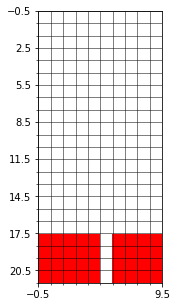

In [47]:
board = np.array(
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

visualize_block(board,(22,10)) #可視化



strategyは、5つの要素から構成される配列です。
※AI組のコードはstrategyではなくactionになっています。

0: ミノの向き

1: ミノの横方向の位置

2: 真下に下ろすか(0:yes 1:no)

3: (下ろす場合)y方向にどれだけ動かすか

4: HOLDするか否か(y: yes n: no)

In [101]:
strategy = (1,5,0,0,'n')


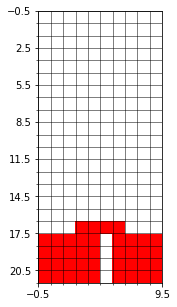

In [102]:
shape_class = Shape(1)
board2 = getBoard(board,shape_class,strategy[0],strategy[1])
visualize_block(board2,shape)

- - -

# 3. ミノを落とす方法を決めよう
・対戦サーバのトレーニングページtest-3のイメージ。あくまで「良さげ度合い」があることに触れるだけで、「良さげ度合い」の計算方法はDay6以降<br>
・辞書型nextMove

一番消せる行が多いものを最適な動かし方として考えます。

下準備：盤面について何列消せるか数える関数をつくろう


In [29]:
def calculateNumOfRows(data, shape):
    #1次元配列を2次元配列へ変換
    data = data.reshape(shape)
    #行方向に足し合わせ
    rows = np.sum(data,axis=1)
    return np.count_nonzero(rows == shape[1])

    

以下の盤面について、消せる行数があっているか確認しましょう。

In [70]:
data = np.array(
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


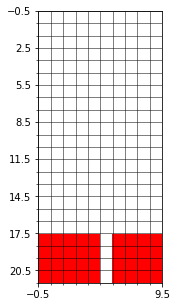

In [36]:
data = np.array(
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

visualize_block(data,(22,10)) #可視化

In [72]:
print("消せる行は{0}行です".format(calculateNumOfRows(data, (22,10))))

消せる行は2行です


今実装した関数を利用して、最適な動かし方をサーチしましょう。

すべてのミノの向き、すべてのミノの位置について、何行消せるかを計算し、一番消せる行が多いものを採用します。

In [106]:
def getmovement(board,shape,shape_class):
    current_ans = -1 #今時点で最大消せる行数
    strategy = (0,0,0,0,'n') #今時点での最適な行動

    #すべての向きで検査
    for direction0 in range(2):
        #すべての位置で検査(はみ出す場合があるから本当は厳密にやりたいけど…)
        for x0 in range(0,10):
            board2 = getBoard(board,shape_class,direction0,x0)
            count_rows = calculateNumOfRows(board2, shape)
            if current_ans < count_rows:
                current_ans = count_rows
                strategy = (direction0, x0, 0, 0, 'n')
    return strategy

In [107]:
getmovement(board,(22,10),shape_class)

(0, 5, 0, 0, 'n')

上で想定したactionと一緒になったでしょうか？

- - -

# 4. 【Day5のHint】ホールド機能を実装しよう
・exchangeHoldShapeに軽〜く触れる

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [35]:
data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]





AttributeError: 'list' object has no attribute 'reshape'